### Import

In [12]:
# librerias basicas
import os
import numpy as np
from copy import deepcopy
from tqdm import tqdm as tqdm
import time
import gc
# graficos
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# videos
import cv2
# Imagenes medicas
import nibabel as nib
# optimizacion
import scipy.linalg
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import linregress
# cargar data
import pickle as pkl
import warnings
# eliminar advertencias
warnings.filterwarnings('ignore')

### Utils

In [4]:
def geo_mean(iterable):
  """
  Compute geometric mean of an array
  """
  a = np.array(iterable)
  return a.prod()**(1.0/len(a))
  
def read_image_data(path, file):
  """
  Read an image from the MNI atlas
  """
  img = nib.load(os.path.join(path, file))
  data = img.get_fdata()
  return data

## Display del MNI atlas

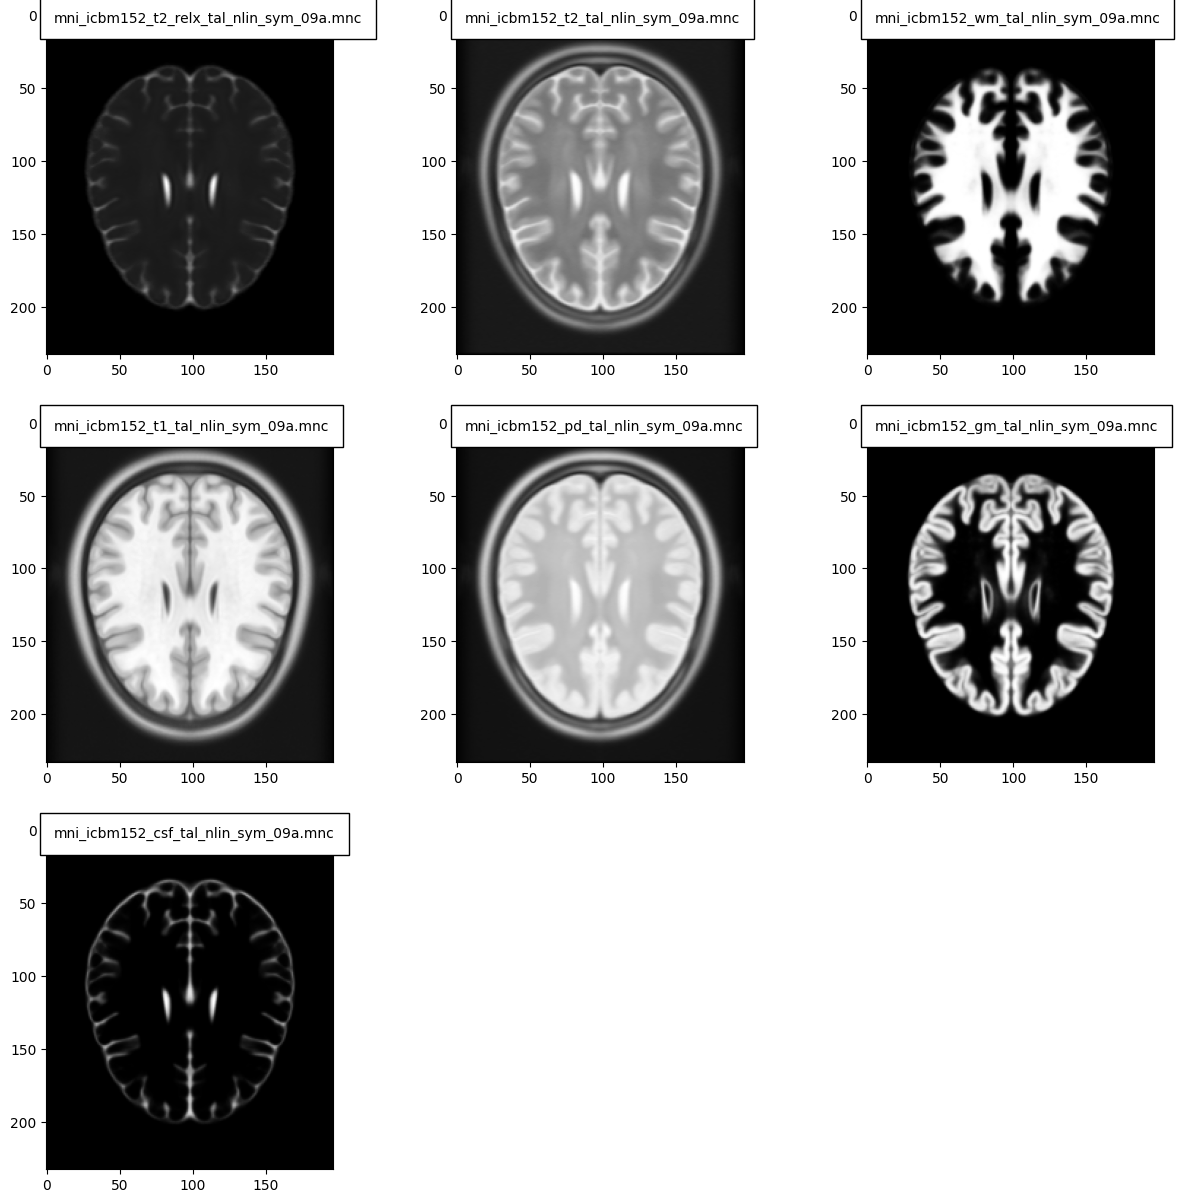

In [10]:
path = '/Users/Maxy/Desktop/tumor_growth/mni_icbm152_nlin_sym_09a_minc2'
files = ['mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t2_tal_nlin_sym_09a.mnc',
         'mni_icbm152_wm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t1_tal_nlin_sym_09a.mnc',
         'mni_icbm152_pd_tal_nlin_sym_09a.mnc',
         'mni_icbm152_gm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_csf_tal_nlin_sym_09a.mnc']
f, ax = plt.subplots(3, 3, figsize=(15,15))
for i, file in enumerate(files):
  k, l = i//3, i%3
  data = read_image_data(path, file)
  ax[k, l].imshow(data[100], cmap="gray")
  ax[k, l].grid(False)
  ax[k, l].text(5, 5, file, bbox={'facecolor': 'white', 'pad': 10})
ax[-1, -2].axis('off')  
ax[-1, -1].axis('off')
f.show()

In [15]:
# Definir los nombres de los archivos para los diferentes tipos de tejido
white_matter = 'mni_icbm152_wm_tal_nlin_sym_09a.mnc'
grey_matter = 'mni_icbm152_gm_tal_nlin_sym_09a.mnc'
csf = 'mni_icbm152_csf_tal_nlin_sym_09a.mnc'
outside_lim = 'mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc'

# Leer las imágenes utilizando la ruta proporcionada y los nombres de archivo
img = read_image_data(path, 'mni_icbm152_t1_tal_nlin_sym_09a.mnc')
wm = read_image_data(path, white_matter)
gm = read_image_data(path, grey_matter)
csf = read_image_data(path, csf)
out = read_image_data(path, outside_lim)

# Función para normalizar un solo frame de la imagen
def normalize_frame_2D(i, img=img):
    # Crear una copia del frame i de la imagen
    img_norm = img[i].copy()
    
    # Establecemos todos los valores menores a 30 en 0
    zero_index = np.where(img_norm < 30)
    img_norm[zero_index] = 0
    
    # Normalizamos los valores de los píxeles al rango [0, 1]
    img_norm = (img_norm - np.min(img_norm)) / (np.max(img_norm) - np.min(img_norm))
    
    # Establecemos regiones específicas de la imagen en diferentes valores según umbrales

    # Indico la región fuera del cerebro en 0
    out_index = np.where(out[i] < 0.08)
    # Indico la región del LCR (líquido cefalorraquídeo) en 0
    csf_index = np.where(csf[i] > 0.15)
    # Indico la región de materia blanca en 1
    wm_index = np.where(wm[i] > 0.5)
    img_norm[out_index], img_norm[csf_index], img_norm[wm_index] = 0, 0, 1
    
    # Establecer la región de materia gris en 0.5
    gm_index = np.where(np.logical_and(img_norm > 0, img_norm < 1))
    img_norm[gm_index] = 0.5
    
    return img_norm

# Función para normalizar todo el volumen de la imagen de RM
def normalize_MRI(img=img):
    # Crear una copia del volumen completo de la imagen
    new_img = img.copy()
    
    # Normalizar cada frame del volumen de la imagen
    for i in range(img.shape[0]):
        new_img[i] = normalize_frame_2D(i, img)
    
    return new_img

# Función para comparar un frame específico antes y después de la normalización
def compare_with_norm(i, img=img):
    # Crear una figura con dos subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Mostrar el frame original antes de la normalización
    ax[0].imshow(1 - img[i], label='Antes de la normalización', cmap="gray")
    ax[0].grid(False)
    ax[0].text(5, 5, 'Imagen cruda ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    
    # Normalizar el frame
    img_norm = normalize_frame_2D(i, img)
    
    # Mostrar el frame después de la normalización
    ax[1].imshow(1 - img_norm, label='Después de la normalización', cmap= "gray")
    ax[1].text(5, 5, 'Imagen binaria ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    ax[1].grid(False)
    
    # Mostrar la figura
    f.show()



Comparamos antes y despues de la normalizacion

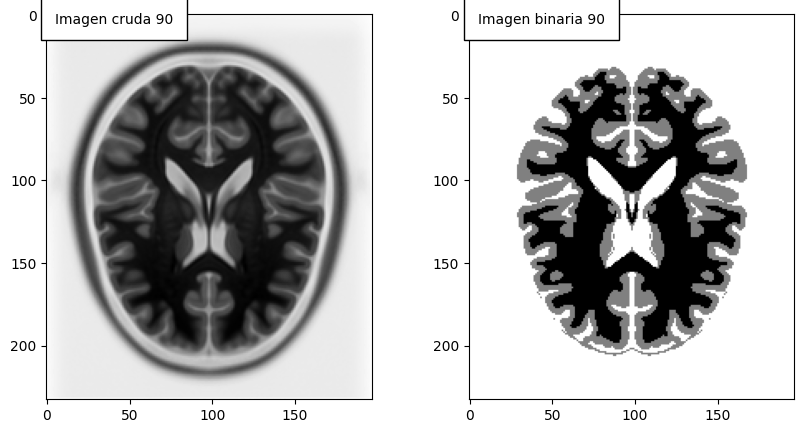

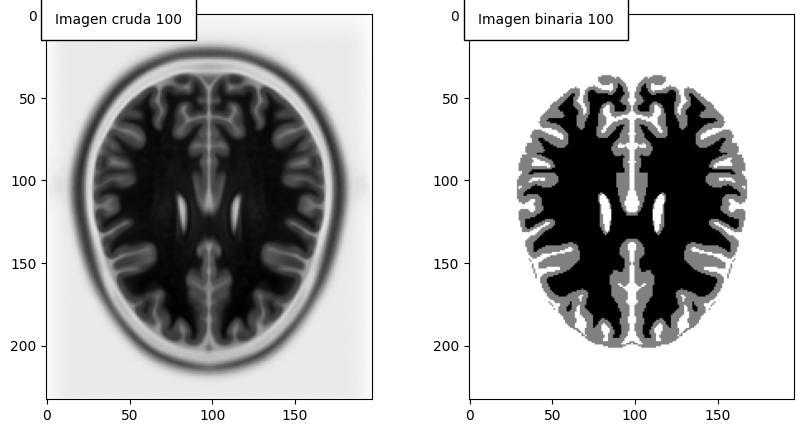

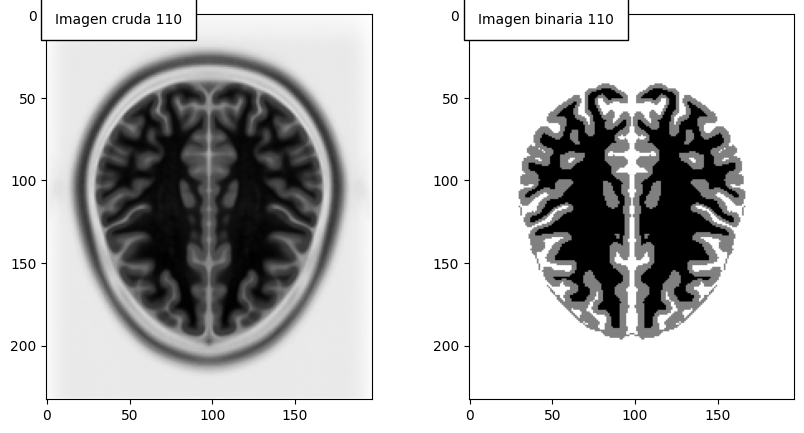

In [16]:
compare_with_norm(90)
compare_with_norm(100)
compare_with_norm(110)

In [ ]:
print()